# 第5章: 係り受け解析
日本語Wikipediaの「人工知能」に関する記事からテキスト部分を抜き出したファイルがai.ja.zipに収録されている． この文章をCaboChaやKNP等のツールを利用して係り受け解析を行い，その結果をai.ja.txt.parsedというファイルに保存せよ．このファイルを読み込み，以下の問に対応するプログラムを実装せよ．

やったこと(参考:https://qiita.com/musaprg/items/9a572ad5c4e28f79d2ae)
```
$ brew install crf++
$ brew install cabocha
$ git clone https://github.com/taku910/cabocha
$ pip install cabocha/python
$ pip add git+https://github.com/kenkov/cabocha@0.1.4

```

## 40. 係り受け解析結果の読み込み（形態素）

形態素を表すクラスMorphを実装せよ．このクラスは表層形（surface），基本形（base），品詞（pos），品詞細分類1（pos1）をメンバ変数に持つこととする．さらに，係り受け解析の結果（ai.ja.txt.parsed）を読み込み，各文をMorphオブジェクトのリストとして表現し，冒頭の説明文の形態素列を表示せよ．

In [64]:
# ライブラリを使っちゃうとこんな感じ
from cabocha.analyzer import CaboChaAnalyzer
import zipfile
with zipfile.ZipFile('files/ai.ja.zip') as zipf:
    with zipf.open('ai.ja.txt',mode='r') as f:
        text = f.read().decode('utf-8')
analyzer = CaboChaAnalyzer()


tree = analyzer.parse(text)
morphs = []
for chunk in tree:
    for token in chunk:
        morphs.append(Morph(token.surface,token.genkei,token.pos,token.pos1))
        
for morph in morphs[:30]:
    print(morph.surface,end=" ")

人工 知能 人工 知能 （ じん こうち のう 、 、 AI 〈 エーアイ 〉 ） と は 、 「 『 計算 （ ） 』 という 概念 と 『 コンピュータ （ 

In [65]:
# ai.ja.txtをXMLにして読み込み
! cat files/ai.ja.txt | cabocha -f3 > files/ai.ja.txt.parsed

In [186]:
!head -200 files/ai.ja.txt.parsed

<sentence>
 <chunk id="0" link="-1" rel="D" score="0.000000" head="1" func="1">
  <tok id="0" feature="名詞,一般,*,*,*,*,人工,ジンコウ,ジンコー">人工</tok>
  <tok id="1" feature="名詞,一般,*,*,*,*,知能,チノウ,チノー">知能</tok>
 </chunk>
</sentence>
<sentence>
</sentence>
<sentence>
 <chunk id="0" link="17" rel="D" score="0.388993" head="1" func="1">
  <tok id="0" feature="名詞,一般,*,*,*,*,人工,ジンコウ,ジンコー">人工</tok>
  <tok id="1" feature="名詞,一般,*,*,*,*,知能,チノウ,チノー">知能</tok>
 </chunk>
 <chunk id="1" link="17" rel="D" score="0.613549" head="4" func="5">
  <tok id="2" feature="記号,括弧開,*,*,*,*,（,（,（">（</tok>
  <tok id="3" feature="名詞,一般,*,*,*,*,じん,ジン,ジン">じん</tok>
  <tok id="4" feature="名詞,一般,*,*,*,*,こうち,コウチ,コーチ">こうち</tok>
  <tok id="5" feature="助詞,終助詞,*,*,*,*,のう,ノウ,ノー">のう</tok>
  <tok id="6" feature="記号,読点,*,*,*,*,、,、,、">、</tok>
  <tok id="7" feature="記号,読点,*,*,*,*,、,、,、">、</tok>
 </chunk>
 <chunk id="2" link="3" rel="D" score="0.758984" head="8" func="8">
  <tok id="8" feature="名詞,一般,*,*,*,*,*">AI</tok>
 </chunk>
 <chunk id="3

In [61]:
# Morphクラス
class Morph:
    def __init__(self, surface, base, pos, pos1):
        self.surface = surface
        self.base = base
        self.pos = pos
        self.pos1 = pos1
    def print(self):
        print(f'surface:{self.surface} base:{self.base} pos:{self.pos} pos1:{self.pos1}')
        

In [64]:
from lxml import etree 
with open('./files/ai.ja.txt.parsed') as f:
    text = ''.join(f.readlines())
root =  etree.XML(f'<root>{text}</root>')
morphs = list()
for element in root.findall('sentence/chunk/tok'):
    pos, pos1, _,_,_,_, base, *_ = element.xpath('@feature')[0].split(',')
    surface = element.text
    morphs.append(Morph(surface,base,pos,pos1))

for morph in morphs[:30]:
    print(morph.surface, end= " ")
    

人工 知能 人工 知能 （ じん こうち のう 、 、 AI 〈 エーアイ 〉 ） と は 、 「 『 計算 （ ） 』 という 概念 と 『 コンピュータ （ 

In [ ]:
for morph in morphs[:30]:
    morph.print()

## 41. 係り受け解析結果の読み込み（文節・係り受け）
40に加えて，文節を表すクラスChunkを実装せよ．このクラスは形態素（Morphオブジェクト）のリスト（morphs），係り先文節インデックス番号（dst），係り元文節インデックス番号のリスト（srcs）をメンバ変数に持つこととする．さらに，入力テキストの係り受け解析結果を読み込み，１文をChunkオブジェクトのリストとして表現し，冒頭の説明文の文節の文字列と係り先を表示せよ．本章の残りの問題では，ここで作ったプログラムを活用せよ．

In [182]:
from  typing import List
class Chunk:
    def __init__(self,id:int,morphs: List[Morph],dst:int,srcs:List[int]):
        self.id = id
        self.morphs = morphs
        self.dst = dst
        self.srcs = srcs
    # 文節を文字列にしたもの
    def phrase(self, is_remove_symbolic_character=False)-> str:
        if not is_remove_symbolic_character:
            return "".join([morph.surface for morph in self.morphs])
        return "".join([morph.surface for morph in self.morphs if morph.pos != "記号"])
    def print(self):
        print(f'id:{self.id} morhps:{self.morphs} dst:{self.dst} srcs:{self.srcs}')
        
        

In [184]:
from lxml import etree 
from collections import defaultdict
class Parser:
    def __init__(self):
        pass
    
    def parse(self,file_name:str) -> List[List[Chunk]]:
        with open('./files/ai.ja.txt.parsed') as f:
            text = ''.join(f.readlines())
        root =  etree.XML(f'<root>{text}</root>')
        sentences = self._parse_root(root)
        return sentences
    
    def _parse_root(self,root) -> List[List[Chunk]]:
        sentences = []
        for sentence_element in root.xpath('sentence'):
            chunks = self._parse_sentence(sentence_element)
            sentences.append(chunks)
        return sentences

        
    def _parse_sentence(self,sentence_element) -> List[Chunk]:
        chunk_dicts = list()
        srcs_dict = defaultdict(list)
        for chunk_element in sentence_element.xpath('chunk'):
            chunk_dict = self._parse_chunk(chunk_element)
            srcs_dict[chunk_dict['dst']].append(chunk_dict['id'])
            chunk_dicts.append(chunk_dict)
        chunks=[Chunk(chunk_dict["id"],chunk_dict["morphs"], chunk_dict["dst"], srcs_dict[chunk_dict["id"]]) for chunk_dict in chunk_dicts]
        return chunks

    def _parse_chunk(self, chunk_element) -> dict:
        chunk_dict = dict()
        morphs = list()
        for tok_element in chunk_element.xpath('tok'):
            morph = self._parse_morph(tok_element)
            morphs.append(morph)
        dst = int(link[0]) if (link := chunk_element.xpath('@link')) else None
        id = int(link[0]) if (link := chunk_element.xpath('@id')) else None

        chunk_dict['morphs'] = morphs
        chunk_dict['id'] = id
        chunk_dict['dst'] = dst
        return chunk_dict

    def _parse_morph(self,tok_element) -> Morph:
        pos, pos1, _,_,_,_, base, *_ = feature[0].split(',') if (feature:=tok_element.xpath("@feature")) else [None,None,None,None,None,None,None,None]
        surface = tok_element.text if tok_element is not None else None
        return Morph(surface,base,pos,pos1)

parser = Parser()
sentences = parser.parse('./files/ai.ja.txt.parsed')
            
    
for chunks in sentences[:5]:
    for chunk in chunks:
        print(f"chunk id:{chunk.id} かかり先:{chunk.dst}", end=" ")
#         surfaces = "".join([morph.surface for morph in chunk.morphs])
        print(f'文節:{chunk.phrase()}')
        print()
    

chunk id:0 かかり先:-1 文節:人工知能

chunk id:0 かかり先:17 文節:人工知能

chunk id:1 かかり先:17 文節:（じんこうちのう、、

chunk id:2 かかり先:3 文節:AI

chunk id:3 かかり先:17 文節:〈エーアイ〉）とは、

chunk id:4 かかり先:5 文節:「『計算

chunk id:5 かかり先:9 文節:（）』という

chunk id:6 かかり先:9 文節:概念と

chunk id:7 かかり先:8 文節:『コンピュータ

chunk id:8 かかり先:9 文節:（）』という

chunk id:9 かかり先:10 文節:道具を

chunk id:10 かかり先:12 文節:用いて

chunk id:11 かかり先:12 文節:『知能』を

chunk id:12 かかり先:13 文節:研究する

chunk id:13 かかり先:14 文節:計算機科学

chunk id:14 かかり先:15 文節:（）の

chunk id:15 かかり先:16 文節:一分野」を

chunk id:16 かかり先:17 文節:指す

chunk id:17 かかり先:34 文節:語。

chunk id:18 かかり先:20 文節:「言語の

chunk id:19 かかり先:20 文節:理解や

chunk id:20 かかり先:21 文節:推論、

chunk id:21 かかり先:22 文節:問題解決などの

chunk id:22 かかり先:24 文節:知的行動を

chunk id:23 かかり先:24 文節:人間に

chunk id:24 かかり先:26 文節:代わって

chunk id:25 かかり先:26 文節:コンピューターに

chunk id:26 かかり先:27 文節:行わせる

chunk id:27 かかり先:34 文節:技術」、または、

chunk id:28 かかり先:29 文節:「計算機

chunk id:29 かかり先:31 文節:（コンピュータ）による

chunk id:30 かかり先:31 文節:知的な

chunk id:31 かかり先:33 文節:情報処理システムの

chunk id:32 かかり先:33 文節:設計や



## 42. 係り元と係り先の文節の表示
係り元の文節と係り先の文節のテキストをタブ区切り形式ですべて抽出せよ．ただし，句読点などの記号は出力しないようにせよ．

In [197]:
# 形態素解析で"記号"となっていないものも省いていてもいいかも
for chunks in sentences:
    chunk_id_dict = {chunk.id:chunk for chunk in chunks}
    for chunk in chunks:
        dst = chunk.dst
        if dst == -1:
            print(f"{chunk.phrase(is_remove_symbolic_character=True)}\t")
            continue
        print(f"{chunk.phrase(is_remove_symbolic_character=True)}\t{chunk_id_dict[dst].phrase(is_remove_symbolic_character=True)}")

人工知能	
人工知能	語
じんこうちのう	語
AI	エーアイとは
エーアイとは	語
計算	という
という	道具を
概念と	道具を
コンピュータ	という
という	道具を
道具を	用いて
用いて	研究する
知能を	研究する
研究する	計算機科学
計算機科学	の
の	一分野を
一分野を	指す
指す	語
語	研究分野とも
言語の	推論
理解や	推論
推論	問題解決などの
問題解決などの	知的行動を
知的行動を	代わって
人間に	代わって
代わって	行わせる
コンピューターに	行わせる
行わせる	技術または
技術または	研究分野とも
計算機	コンピュータによる
コンピュータによる	情報処理システムの
知的な	情報処理システムの
情報処理システムの	実現に関する
設計や	実現に関する
実現に関する	研究分野とも
研究分野とも	される
される	
日本大百科全書(ニッポニカ)』の	解説で
解説で	述べている
情報工学者通信工学者の	佐藤理史は
佐藤理史は	述べている
次のように	述べている
述べている	
人間の	知的能力を
知的能力を	実現する
コンピュータ上で	実現する
実現する	技術ソフトウェアコンピュータシステム
様々な	技術ソフトウェアコンピュータシステム
技術ソフトウェアコンピュータシステム	ある
応用例は	ある
自然言語処理	機械翻訳かな漢字変換構文解析等
機械翻訳かな漢字変換構文解析等	専門家の
専門家の	推論判断を
推論判断を	模倣する
模倣する	エキスパートシステム
エキスパートシステム	画像認識等が
画像データを	解析して
解析して	検出抽出したりする
特定の	パターンを
パターンを	検出抽出したりする
検出抽出したりする	画像認識等が
画像認識等が	ある
ある	命名された
1956年に	命名された
ダートマス会議で	命名された
ジョンマッカーシーにより	命名された
命名された	使われている
現在では	使われている
記号処理を	用いた
用いた	知能の
知能の	記述を
記述を	する
主体と	する
する	研究での
情報処理や	研究での
研究での	アプローチという
アプローチという	意味あいでも
意味あいでも	使われている
使われている	ある
家庭用電気機械器具の	制御システムや
制御システムや	思考ルーチンも
ゲームソフトの	思考ルーチンも
思考ルーチンも	呼ばれる

ために	必要だと
全人体シミュレーションが	必要だと
必要だと	する
する	研究者やより
研究者やより	近い
生物に	近い
近い	振る舞いを
振る舞いを	見せる
見せる	AL
AL	知能と
人工生命の	作成に
作成に	挑む
挑む	研究者
研究者	知能と
知能と	関係に
密接な	関係に
関係に	あると
あると	思われる
思われる	意識の
意識の	デジタル的再現
デジタル的再現	人工意識に
人工意識に	挑戦する
挑戦する	研究者も
研究者も	いる
いる	
リーズナブルな	コストで
コストで	入るようになった
大量の	計算リソースが
計算リソースが	入るようになった
手に	入るようになった
入るようになった	ことで
ことで	寄せており
ビッグデータが	出現し
出現し	寄せており
企業が	寄せており
膨大な	データの
データの	活用に
活用に	寄せており
極めて	強い
強い	関心を
関心を	寄せており
寄せており	展開されている
全世界的に	行って
民間企業主導で	行って
莫大な	投資を
投資を	行って
行って	展開されている
人工知能に関する	研究開発競争が
研究開発競争が	展開されている
展開されている	整備され始めている
また	整備され始めている
2011年の	D-WaveSystemsによる
D-WaveSystemsによる	量子アニーリング方式の
量子アニーリング方式の	製品化を
製品化を	嚆矢として
嚆矢として	実用化され始めた
量子コンピュータという	超並列処理が
超並列処理が	可能な
可能な	次世代の
次世代の	ITインフラが
ITインフラが	実用化され始めた
急速に	実用化され始めた
実用化され始めた	事で
事で	整備され始めている
人工知能の	高速化にも
高速化にも	関わる
深く	関わる
関わる	組み合わせ最適化問題を
組み合わせ最適化問題を	解決できる
リアルタイムに	解決できる
解決できる	環境が
環境が	整備され始めている
整備され始めている	目立つようになった
この	動向を
動向を	受ける
受ける	形で
形で	目立つようになった
2016年頃から	目立つようになった
一般向けの	ニュース番組でも
ニュース番組でも	目立つようになった
人工知能の	量子コンピュータに関する
研究開発や	量子コンピュータに関する
新しい	量子コンピュータに関する
サー

攻撃したり	なりすましたり
ディープフェイクで	なりすましたり
なりすましたり	操る
ボット投稿により	操る
世論を	操る
操る	等の
等の	懸念が
懸念が	挙げられている
挙げられている	
Googleは	発表した
2019年	3月
3月	設置すると
人工知能プロジェクトを	指導する
倫理面で	指導する
指導する	ために
ために	構成される
哲学者政策立案者経済学者テクノロジスト等で	構成される
構成される	設置すると
AI倫理委員会を	設置すると
設置すると	発表した
発表した	要請した
しかし	要請した
倫理委員会には	含まれており
反科学反マイノリティ・地球温暖化懐疑論等を	支持する
支持する	人物も
人物も	含まれており
含まれており	要請した
Google社員らは	要請した
解任を	要請した
要請した	発表した
4月4日	発表した
Googleは	発表した
倫理委員会が	発表した
期待どおりに	機能できない
機能できない	ことが
ことが	判明したという
判明したという	理由で
理由で	発表した
委員会の	解散を
解散を	発表した
発表した	
東洋哲学を	吸収させるという
AIに	吸収させるという
吸収させるという	三宅陽一郎の
三宅陽一郎の	テーマに
テーマに	応じて
応じて	語る
井口尊仁は	挙げ
鳥居TORIIという	自分の
自分の	プロジェクトを
プロジェクトを	挙げ
挙げ	語る
われわれは	アニミズムで
アニミズムで	ありますと
あらゆる	ものに
ものに	見いだす
霊的存在を	見いだす
見いだす	文化が
文化が	ありますと
ありますと	語る
三宅および	立石従寛に
立石従寛に	語る
語る	通じている
アニミズム的人工知能論は	通じている
現代アートや	哲学塾東洋哲学篇にも
禅の	悟りを
悟りを	やって
どう	やって
やって	やらせるかを
AIに	やらせるかを
やらせるかを	論じた
論じた	三宅の
三宅の	哲学塾東洋哲学篇にも
人工知能の	ための
ための	哲学塾東洋哲学篇にも
哲学塾東洋哲学篇にも	通じている
通じている	
元Googleエンジニアの	アンソニーレバンドウスキーは
アンソニーレバンドウスキーは	示している
2017年	示している
AIを	する
神と	する
する	宗教団体
宗教団体	示している
WayoftheFuture(未来の	道

## 43. 名詞を含む文節が動詞を含む文節に係るものを抽出
名詞を含む文節が，動詞を含む文節に係るとき，これらをタブ区切り形式で抽出せよ．ただし，句読点などの記号は出力しないようにせよ．

In [215]:
# 形態素解析で"記号"となっていないものも省いていてもいいかも
def is_contain_verb(chunk:Chunk) -> bool:
    for morph in chunk.morphs:
        if morph.pos == "動詞":
            return True
    return False

def is_contain_noun(chunk:Chunk) -> bool:
    for morph in chunk.morphs:
        if morph.pos == "名詞":
            return True
    return False

for idx,chunks in enumerate(sentences):
    print(f"sentence:{idx}")
    chunk_id_dict = {chunk.id:chunk for chunk in chunks}
    for chunk in chunks:
        dst = chunk.dst
        if dst == -1:
            continue
        if is_contain_noun(chunk) and is_contain_verb(chunk_id_dict[dst]):
            print(f"{chunk.phrase(is_remove_symbolic_character=True)}\t{chunk_id_dict[dst].phrase(is_remove_symbolic_character=True)}")

sentence:0
sentence:1
sentence:2
道具を	用いて
知能を	研究する
一分野を	指す
知的行動を	代わって
人間に	代わって
コンピューターに	行わせる
研究分野とも	される
sentence:3
sentence:4
解説で	述べている
佐藤理史は	述べている
次のように	述べている
sentence:5
知的能力を	実現する
コンピュータ上で	実現する
技術ソフトウェアコンピュータシステム	ある
応用例は	ある
推論判断を	模倣する
画像データを	解析して
解析して	検出抽出したりする
パターンを	検出抽出したりする
画像認識等が	ある
1956年に	命名された
ダートマス会議で	命名された
ジョンマッカーシーにより	命名された
命名された	使われている
現在では	使われている
記号処理を	用いた
記述を	する
主体と	する
意味あいでも	使われている
思考ルーチンも	呼ばれる
ことも	ある
sentence:6
sentence:7
カウンセラーを	模倣した
プログラム	出されるが
人工無脳が	出されるが
引き合いに	出されるが
計算機に	させようという
役割を	させようという
エキスパートシステムと	呼ばれる
実現は	困難視されている
人間が	持つ
暗黙に	持つ
記述が	なり
問題と	なり
利用が	困難視されている
困難視されている	ある
アプローチとしては	知られているが
アプローチも	知られているが
差は	ある
記号的明示性に	ある
その後	集めた
サポートベクターマシンが	集めた
注目を	集めた
経験を	行う
元に	行う
学習を	行う
手法も	ある
宇宙において	実装するという
言葉通り	実装するという
知性を	表現し
機械的に	表現し
表現し	実装するという
sentence:8
sentence:9
登場により	行った
流行を	超えて
社会に	浸透して
浸透して	行った
2017年にかけて	導入した
ディープラーニングを	導入した
プレイヤーも	破り
麻雀では	なった
MicrosoftSuphx(SuperPhoenix)」が	到達するなど
AIとして	到達するなど
十段に	到達するなど
到達するなど	なった
最先端技術と	なった
sentence:10
sentence:11
人工知能は	呼ばれ
機械学習と	呼ばれ

対談で	答えている
須藤は	発言し
これまで	行ってきました
長時間	行ってきました
議論を	行ってきました
おかげで	明らかになったとは
違いは	明らかになったとは
明らかになったとは	思いますが
何か	つくのでしょうかと
決着が	つくのでしょうかと
つくのでしょうかと	発言し
発言し	答えている
伊勢田は	答えている
決着は	つかないでしょうねと


## 44. 係り受け木の可視化
与えられた文の係り受け木を有向グラフとして可視化せよ．可視化には，Graphviz等を用いるとよい

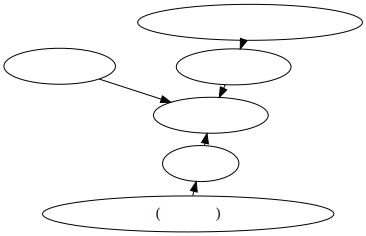

In [228]:
# 参考
# https://networkx.github.io/documentation/stable/index.html
# https://qiita.com/hitsumabushi845/items/270d81c5c8017014df95
# https://qiita.com/kzm4269/items/081ff2fdb8a6b0a6112f

import networkx as nx
from IPython.display import SVG, display
# グラフ定義
G = nx.DiGraph()
for chunks in sentences[4:5]:
    chunk_id_dict = {chunk.id:chunk for chunk in chunks}
    for chunk in chunks:
        dst = chunk.dst
        if dst == -1:
            G.add_node(chunk.phrase(is_remove_symbolic_character=True))
            continue
        #         
        nx.add_path(G, [chunk.phrase(is_remove_symbolic_character=True),chunk_id_dict[dst].phrase(is_remove_symbolic_character=True)])


# TODO:意味を理解する
svg = SVG(nx.nx_agraph.to_agraph(G).draw(prog='fdp', format='svg'))
display(svg)


## 45. 動詞の格パターンの抽出
今回用いている文章をコーパスと見なし，日本語の述語が取りうる格を調査したい． 動詞を述語，動詞に係っている文節の助詞を格と考え，述語と格をタブ区切り形式で出力せよ． ただし，出力は以下の仕様を満たすようにせよ．

- 動詞を含む文節において，最左の動詞の基本形を述語とする
- 述語に係る助詞を格とする
- 述語に係る助詞（文節）が複数あるときは，すべての助詞をスペース区切りで辞書順に並べる

「ジョン・マッカーシーはAIに関する最初の会議で人工知能という用語を作り出した。」という例文を考える． この文は「作り出す」という１つの動詞を含み，「作り出す」に係る文節は「ジョン・マッカーシーは」，「会議で」，「用語を」であると解析された場合は，次のような出力になるはずである．
```
作り出す	で は を
```
このプログラムの出力をファイルに保存し，以下の事項をUNIXコマンドを用いて確認せよ．

- コーパス中で頻出する述語と格パターンの組み合わせ
- 「行う」「なる」「与える」という動詞の格パターン（コーパス中で出現頻度の高い順に並べよ）

In [248]:
line = ""
for chunks in sentences:
    chunk_id_dict = {chunk.id:chunk for chunk in chunks}
    for chunk in chunks:

        for morph in chunk.morphs:
            if morph.pos != "動詞":
                continue
            line += f"{morph.base}\t"
            postpositions = []
            for src in chunk.srcs:
                for morph in chunk_id_dict[src].morphs:
                    if morph.pos != "助詞":
                        continue
                    postpositions.append(morph.base)
            # 辞書順ソート            
            line += ' '.join(sorted(set(postpositions)))
            line += "\n"            
            break
with open('files/45.txt',mode='w') as f:
    f.write(line)

                

In [252]:
! cat files/45.txt | sort | uniq -c | sort -k 1 -n -r 

  49 する	を
  19 する	が
  15 する	に
  15 する	と
  12 する	は を
  10 する	に を
   9 する	で を
   9 よる	に
   8 する	が に
   8 行う	を
   8 する	
   6 基づく	に
   6 する	と は
   6 呼ぶ	と
   5 する	に は を
   5 する	と を
   5 する	が を
   5 ある	が
   4 関わる	に も
   4 用いる	を
   4 する	で に
   4 する	て を
   4 する	て と
   4 使う	を
   3 述べる	と
   3 超える	を
   3 向ける	に
   3 受ける	を
   3 する	て に は
   3 なる	に は
   3 なる	が と
   3 する	が で
   3 持つ	を
   3 入る	に
   3 する	は
   2 導き出す	を
   2 上回る	で を
   2 考える	
   2 する	について
   2 する	として
   2 する	から を
   2 する	が として に
   2 する	が に は を
   2 示す	て は を
   2 含む	に は も
   2 する	と に は
   2 する	で は を
   2 する	で に を
   2 する	て と は
   2 する	が で を
   2 持つ	が を
   2 する	に は
   2 する	て に
   2 する	が て
   2 ある	て も
   2 語る	を
   2 至る	に
   2 経る	を
   2 扱う	を
   2 なる	に
   2 なる	と
   2 する	で
   2 する	て
   2 いう	と
   2 ある	も
   2 思う	
   1 組み合わせる	を
   1 巻き起こす	だけ て に は を
   1 位置づける	から に を
   1 なりすます	たり で
   1 関連付ける	と など
   1 取り上げる	が て など は ば
   1 立ち上がる	て と に も
   1 受け止める	て は
   1 漕ぎ着ける	に
   1 推し進める	が
   1 取り上げる	を
   1 生まれる	によって
   1 生まれる	から
   1 生み出す	が によって
   1 盛り込む	

In [254]:
! grep -E "^(行う|なる|与える)" files/45.txt | sort | uniq -c | sort -k 1 -n -r 

   8 行う	を
   3 なる	に は
   3 なる	が と
   2 なる	に
   2 なる	と
   1 与える	が など に
   1 与える	に は を
   1 与える	が に
   1 なる	から が て で と は
   1 なる	から で と
   1 行う	まで を
   1 行う	から
   1 なる	て として に は
   1 行う	に により を
   1 行う	に まで を
   1 行う	は を をめぐって
   1 なる	が と にとって は
   1 なる	で と など は
   1 行う	が て で に は
   1 なる	が で と に は
   1 行う	が で に は
   1 行う	で に を
   1 行う	て に を
   1 行う	て に は
   1 行う	が で は
   1 なる	に は も
   1 なる	で に は
   1 なる	て に は
   1 なる	が に は
   1 なる	が て と
   1 行う	は を
   1 行う	に を
   1 行う	で を
   1 行う	て を
   1 行う	て に
   1 なる	で は
   1 なる	が に
   1 行う	に
   1 なる	も
   1 なる	は
   1 なる	


## 46. 動詞の格フレーム情報の抽出
45のプログラムを改変し，述語と格パターンに続けて項（述語に係っている文節そのもの）をタブ区切り形式で出力せよ．45の仕様に加えて，以下の仕様を満たすようにせよ．

- 項は述語に係っている文節の単語列とする（末尾の助詞を取り除く必要はない）
- 述語に係る文節が複数あるときは，助詞と同一の基準・順序でスペース区切りで並べる

「ジョン・マッカーシーはAIに関する最初の会議で人工知能という用語を作り出した。」という例文を考える． この文は「作り出す」という１つの動詞を含み，「作り出す」に係る文節は「ジョン・マッカーシーは」，「会議で」，「用語を」であると解析された場合は，次のような出力になるはずである．
```
作り出す	で は を	会議で ジョンマッカーシーは 用語を
```

## 47. 機能動詞構文のマイニング
動詞のヲ格にサ変接続名詞が入っている場合のみに着目したい．46のプログラムを以下の仕様を満たすように改変せよ．

- 「サ変接続名詞+を（助詞）」で構成される文節が動詞に係る場合のみを対象とする
- 述語は「サ変接続名詞+を+動詞の基本形」とし，文節中に複数の動詞があるときは，最左の動詞を用いる
- 述語に係る助詞（文節）が複数あるときは，すべての助詞をスペース区切りで辞書順に並べる
- 述語に係る文節が複数ある場合は，すべての項をスペース区切りで並べる（助詞の並び順と揃えよ）
例えば「また、自らの経験を元に学習を行う強化学習という手法もある。」という文から，以下の出力が得られるはずである．
```
学習を行う	に を	元に 経験を
```

## 48. 名詞から根へのパスの抽出
文中のすべての名詞を含む文節に対し，その文節から構文木の根に至るパスを抽出せよ． ただし，構文木上のパスは以下の仕様を満たすものとする．

- 各文節は（表層形の）形態素列で表現する
- パスの開始文節から終了文節に至るまで，各文節の表現を” -> “で連結する
「ジョン・マッカーシーはAIに関する最初の会議で人工知能という用語を作り出した。」という例文を考える． CaboChaを係り受け解析に用いた場合，次のような出力が得られると思われる．
```
ジョンマッカーシーは -> 作り出した
AIに関する -> 最初の -> 会議で -> 作り出した
最初の -> 会議で -> 作り出した
会議で -> 作り出した
人工知能という -> 用語を -> 作り出した
用語を -> 作り出した
```
KNPを係り受け解析に用いた場合，次のような出力が得られると思われる．
```
ジョンマッカーシーは -> 作り出した
ＡＩに -> 関する -> 会議で -> 作り出した
会議で -> 作り出した
人工知能と -> いう -> 用語を -> 作り出した
用語を -> 作り出した
```

## 49. 名詞間の係り受けパスの抽出
文中のすべての名詞句のペアを結ぶ最短係り受けパスを抽出せよ．ただし，名詞句ペアの文節番号がiとj（i<j）のとき，係り受けパスは以下の仕様を満たすものとする．

- 問題48と同様に，パスは開始文節から終了文節に至るまでの各文節の表現（表層形の形態素列）を” -> “で連結して表現する
- 文節iとjに含まれる名詞句はそれぞれ，XとYに置換する
また，係り受けパスの形状は，以下の2通りが考えられる．

- 文節iから構文木の根に至る経路上に文節jが存在する場合: 文節iから文節jのパスを表示
- 上記以外で，文節iと文節jから構文木の根に至る経路上で共通の文節kで交わる場合: 文節iから文節kに至る直前のパスと文節jから文節kに至る直前までのパス，文節kの内容を” | “で連結して表示
「ジョン・マッカーシーはAIに関する最初の会議で人工知能という用語を作り出した。」という例文を考える． CaboChaを係り受け解析に用いた場合，次のような出力が得られると思われる．
```
Xは | Yに関する -> 最初の -> 会議で | 作り出した
Xは | Yの -> 会議で | 作り出した
Xは | Yで | 作り出した
Xは | Yという -> 用語を | 作り出した
Xは | Yを | 作り出した
Xに関する -> Yの
Xに関する -> 最初の -> Yで
Xに関する -> 最初の -> 会議で | Yという -> 用語を | 作り出した
Xに関する -> 最初の -> 会議で | Yを | 作り出した
Xの -> Yで
Xの -> 会議で | Yという -> 用語を | 作り出した
Xの -> 会議で | Yを | 作り出した
Xで | Yという -> 用語を | 作り出した
Xで | Yを | 作り出した
```
Xという -> Yを
KNPを係り受け解析に用いた場合，次のような出力が得られると思われる．
```
Xは | Yに -> 関する -> 会議で | 作り出した。
Xは | Yで | 作り出した。
Xは | Yと -> いう -> 用語を | 作り出した。
Xは | Yを | 作り出した。
Xに -> 関する -> Yで
Xに -> 関する -> 会議で | Yと -> いう -> 用語を | 作り出した。
Xに -> 関する -> 会議で | Yを | 作り出した。
Xで | Yと -> いう -> 用語を | 作り出した。
Xで | Yを | 作り出した。
Xと -> いう -> Yを
```